In [1]:
import pandas as pd

data_dir = r"C:\Users\andras.janko\Documents\CensusIncomePrediction\_data"
X_train = pd.read_csv(f"{data_dir}/X_train.csv")
X_test = pd.read_csv(f"{data_dir}/X_test.csv")
y_train = pd.read_csv(f"{data_dir}/y_train.csv").squeeze()
y_test = pd.read_csv(f"{data_dir}/y_test.csv").squeeze()

In [2]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

results = {}

# 1. Baseline: always predict majority class
baseline_acc = y_test.value_counts(normalize=True).iloc[0]
print(f"=== Baseline (always predict <=50K) ===")
print(f"Accuracy: {baseline_acc:.4f}\n")

# 2. Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]
results['Random Forest'] = {'acc': accuracy_score(y_test, rf_pred), 'auc': roc_auc_score(y_test, rf_proba)}
print(f"=== Random Forest ===")
print(f"Accuracy: {results['Random Forest']['acc']:.4f}")
print(f"ROC AUC:  {results['Random Forest']['auc']:.4f}")
print(classification_report(y_test, rf_pred, target_names=['<=50K', '>50K']))

# 3. XGBoost
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42,
                     eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_proba = xgb.predict_proba(X_test)[:, 1]
results['XGBoost'] = {'acc': accuracy_score(y_test, xgb_pred), 'auc': roc_auc_score(y_test, xgb_proba)}
print(f"=== XGBoost ===")
print(f"Accuracy: {results['XGBoost']['acc']:.4f}")
print(f"ROC AUC:  {results['XGBoost']['auc']:.4f}")
print(classification_report(y_test, xgb_pred, target_names=['<=50K', '>50K']))

# 4. Extra Trees
et = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
et.fit(X_train, y_train)
et_pred = et.predict(X_test)
et_proba = et.predict_proba(X_test)[:, 1]
results['Extra Trees'] = {'acc': accuracy_score(y_test, et_pred), 'auc': roc_auc_score(y_test, et_proba)}
print(f"=== Extra Trees ===")
print(f"Accuracy: {results['Extra Trees']['acc']:.4f}")
print(f"ROC AUC:  {results['Extra Trees']['auc']:.4f}")
print(classification_report(y_test, et_pred, target_names=['<=50K', '>50K']))

# Summary
print("=== Summary ===")
print(f"{'Model':<20} {'Accuracy':<12} {'ROC AUC':<12}")
print(f"{'Baseline':<20} {baseline_acc:<12.4f} {'N/A':<12}")
for name, m in results.items():
    print(f"{name:<20} {m['acc']:<12.4f} {m['auc']:<12.4f}")

=== Baseline (always predict <=50K) ===
Accuracy: 0.7593

=== Random Forest ===
Accuracy: 0.8477
ROC AUC:  0.8912
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      4945
        >50K       0.71      0.62      0.66      1568

    accuracy                           0.85      6513
   macro avg       0.80      0.77      0.78      6513
weighted avg       0.84      0.85      0.84      6513

=== XGBoost ===
Accuracy: 0.8729
ROC AUC:  0.9245
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      4945
        >50K       0.78      0.65      0.71      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.80      0.82      6513
weighted avg       0.87      0.87      0.87      6513

=== Extra Trees ===
Accuracy: 0.8336
ROC AUC:  0.8483
              precision    recall  f1-score   support

       <=50K       0.88      0.91      0.89      4945
        >50K       

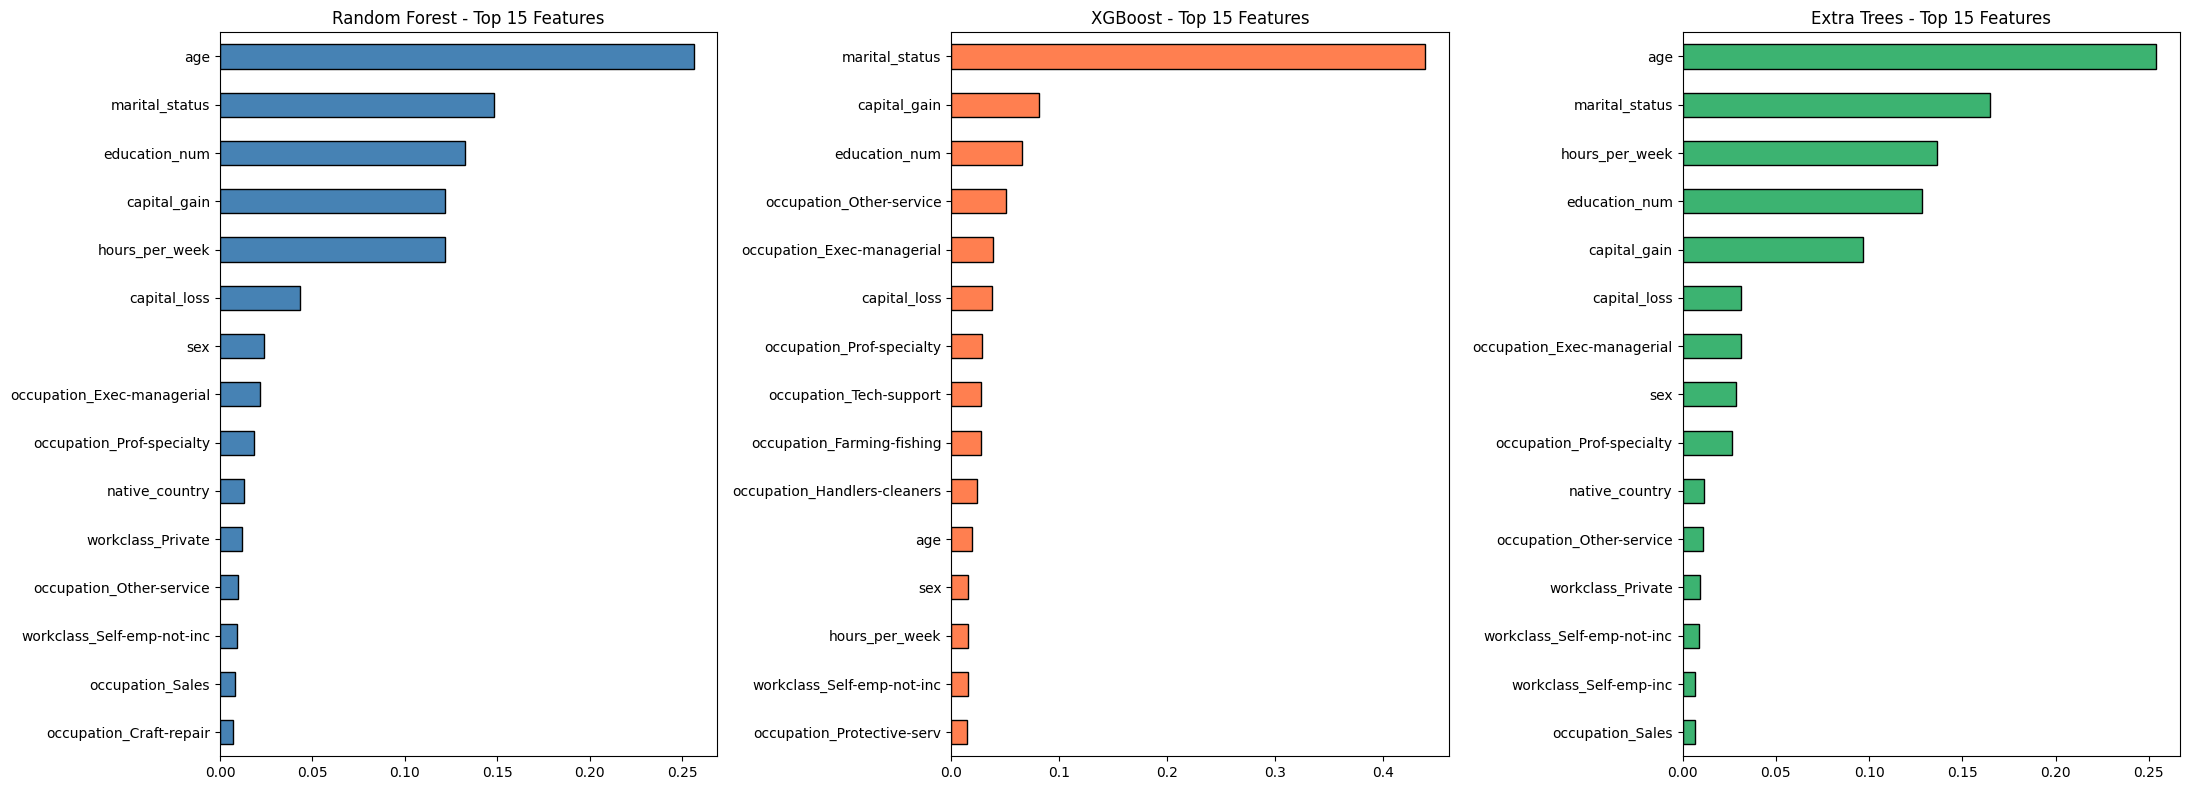

=== Top 10 Features ===
Rank   Random Forest                  XGBoost                        Extra Trees                   
1      age                       0.2562   marital_status            0.4385   age                       0.2540
2      marital_status            0.1484   capital_gain              0.0813   marital_status            0.1649
3      education_num             0.1327   education_num             0.0656   hours_per_week            0.1364
4      capital_gain              0.1216   occupation_Other-service  0.0508   education_num             0.1285
5      hours_per_week            0.1216   occupation_Exec-managerial 0.0384   capital_gain              0.0968
6      capital_loss              0.0431   capital_loss              0.0373   capital_loss              0.0313
7      sex                       0.0240   occupation_Prof-specialty 0.0281   occupation_Exec-managerial 0.0311
8      occupation_Exec-managerial 0.0219   occupation_Tech-support   0.0277   sex                       

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(22, 8))

# Random Forest feature importance
rf_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=True)
rf_imp.tail(15).plot.barh(ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Random Forest - Top 15 Features')

# XGBoost feature importance
xgb_imp = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=True)
xgb_imp.tail(15).plot.barh(ax=axes[1], color='coral', edgecolor='black')
axes[1].set_title('XGBoost - Top 15 Features')

# Extra Trees feature importance
et_imp = pd.Series(et.feature_importances_, index=X_train.columns).sort_values(ascending=True)
et_imp.tail(15).plot.barh(ax=axes[2], color='mediumseagreen', edgecolor='black')
axes[2].set_title('Extra Trees - Top 15 Features')

plt.tight_layout()
plt.show()

# Text version
print("=== Top 10 Features ===")
print(f"{'Rank':<6} {'Random Forest':<30} {'XGBoost':<30} {'Extra Trees':<30}")
rf_top = rf_imp.sort_values(ascending=False).head(10)
xgb_top = xgb_imp.sort_values(ascending=False).head(10)
et_top = et_imp.sort_values(ascending=False).head(10)
for i in range(10):
    print(f"{i+1:<6} {rf_top.index[i]:<25} {rf_top.values[i]:.4f}   {xgb_top.index[i]:<25} {xgb_top.values[i]:.4f}   {et_top.index[i]:<25} {et_top.values[i]:.4f}")

In [4]:
from sklearn.metrics import precision_recall_curve

# XGBoost with scale_pos_weight to handle imbalance
# ratio of negative to positive class
scale_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Class imbalance ratio: {scale_ratio:.2f}\n")

xgb_balanced = XGBClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=6,
    scale_pos_weight=scale_ratio, random_state=42, eval_metric='logloss'
)
xgb_balanced.fit(X_train, y_train)
xgb_bal_pred = xgb_balanced.predict(X_test)
xgb_bal_proba = xgb_balanced.predict_proba(X_test)[:, 1]

print("=== XGBoost (balanced) ===")
print(f"Accuracy: {accuracy_score(y_test, xgb_bal_pred):.4f}")
print(f"ROC AUC:  {roc_auc_score(y_test, xgb_bal_proba):.4f}")
print(classification_report(y_test, xgb_bal_pred, target_names=['<=50K', '>50K']))

# Threshold tuning on original XGBoost
print("=== Original XGBoost - Threshold Analysis ===")
for threshold in [0.3, 0.35, 0.4, 0.45, 0.5]:
    preds = (xgb_proba >= threshold).astype(int)
    acc = accuracy_score(y_test, preds)
    prec = precision_recall_curve(y_test, xgb_proba)
    report = classification_report(y_test, preds, target_names=['<=50K', '>50K'], output_dict=True)
    print(f"Threshold {threshold}: Acc={acc:.4f}  >50K Precision={report['>50K']['precision']:.3f}  >50K Recall={report['>50K']['recall']:.3f}  >50K F1={report['>50K']['f1-score']:.3f}")

Class imbalance ratio: 3.15

=== XGBoost (balanced) ===
Accuracy: 0.8314
ROC AUC:  0.9235
              precision    recall  f1-score   support

       <=50K       0.94      0.83      0.88      4945
        >50K       0.61      0.85      0.71      1568

    accuracy                           0.83      6513
   macro avg       0.78      0.84      0.79      6513
weighted avg       0.86      0.83      0.84      6513

=== Original XGBoost - Threshold Analysis ===
Threshold 0.3: Acc=0.8445  >50K Precision=0.638  >50K Recall=0.818  >50K F1=0.717
Threshold 0.35: Acc=0.8563  >50K Precision=0.675  >50K Recall=0.779  >50K F1=0.723
Threshold 0.4: Acc=0.8657  >50K Precision=0.714  >50K Recall=0.737  >50K F1=0.725
Threshold 0.45: Acc=0.8706  >50K Precision=0.752  >50K Recall=0.691  >50K F1=0.720
Threshold 0.5: Acc=0.8729  >50K Precision=0.784  >50K Recall=0.652  >50K F1=0.712


In [5]:
import optuna
from sklearn.model_selection import cross_val_score
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 600, step=50),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
    }

    model = XGBClassifier(**params, random_state=42, eval_metric='logloss', n_jobs=-1)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100, show_progress_bar=True)

print(f"Best ROC AUC (CV): {study.best_value:.4f}")
print(f"Best params:\n{study.best_params}")

# Evaluate best model on test set
best_xgb = XGBClassifier(**study.best_params, random_state=42, eval_metric='logloss', n_jobs=-1)
best_xgb.fit(X_train, y_train)
best_pred = best_xgb.predict(X_test)
best_proba = best_xgb.predict_proba(X_test)[:, 1]

print(f"\n=== Best XGBoost (Optuna) on Test Set ===")
print(f"Accuracy: {accuracy_score(y_test, best_pred):.4f}")
print(f"ROC AUC:  {roc_auc_score(y_test, best_proba):.4f}")
print(classification_report(y_test, best_pred, target_names=['<=50K', '>50K']))

c:\Users\andras.janko\Documents\CensusIncomePrediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Best trial: 94. Best value: 0.929672: 100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


Best ROC AUC (CV): 0.9297
Best params:
{'max_depth': 5, 'learning_rate': 0.055552850564672865, 'n_estimators': 250, 'min_child_weight': 1, 'subsample': 0.9551956629000853, 'colsample_bytree': 0.74244249119936, 'gamma': 0.28361083099106926, 'reg_alpha': 3.873817893843489e-05, 'reg_lambda': 0.00034051513286596845}

=== Best XGBoost (Optuna) on Test Set ===
Accuracy: 0.8713
ROC AUC:  0.9243
              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.92      4945
        >50K       0.79      0.64      0.71      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.79      0.81      6513
weighted avg       0.87      0.87      0.87      6513



In [6]:
import optuna
from sklearn.model_selection import cross_val_score
optuna.logging.set_verbosity(optuna.logging.WARNING)

def et_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    model = ExtraTreesClassifier(**params, random_state=42, n_jobs=-1)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

et_sampler = optuna.samplers.TPESampler(seed=42)
et_study = optuna.create_study(direction='maximize', sampler=et_sampler)
et_study.optimize(et_objective, n_trials=100, show_progress_bar=True)

print(f"Best ROC AUC (CV): {et_study.best_value:.4f}")
print(f"Best params:\n{et_study.best_params}")

# Evaluate best model on test set
best_et = ExtraTreesClassifier(**et_study.best_params, random_state=42, n_jobs=-1)
best_et.fit(X_train, y_train)
best_et_pred = best_et.predict(X_test)
best_et_proba = best_et.predict_proba(X_test)[:, 1]

print(f"\n=== Best Extra Trees (Optuna) on Test Set ===")
print(f"Accuracy: {accuracy_score(y_test, best_et_pred):.4f}")
print(f"ROC AUC:  {roc_auc_score(y_test, best_et_proba):.4f}")
print(classification_report(y_test, best_et_pred, target_names=['<=50K', '>50K']))

Best trial: 69. Best value: 0.917986: 100%|██████████| 100/100 [13:34<00:00,  8.15s/it]


Best ROC AUC (CV): 0.9180
Best params:
{'n_estimators': 550, 'max_depth': 15, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 0.9725230248665848, 'bootstrap': False}

=== Best Extra Trees (Optuna) on Test Set ===
Accuracy: 0.8652
ROC AUC:  0.9144
              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.91      4945
        >50K       0.78      0.61      0.69      1568

    accuracy                           0.87      6513
   macro avg       0.83      0.78      0.80      6513
weighted avg       0.86      0.87      0.86      6513



In [8]:
from sklearn.metrics import confusion_matrix

models = {
    'Random Forest (default)': (rf_pred, rf_proba),
    'XGBoost (default)': (xgb_pred, xgb_proba),
    'XGBoost (balanced)': (xgb_bal_pred, xgb_bal_proba),
    'XGBoost (Optuna)': (best_pred, best_proba),
    'Extra Trees (default)': (et_pred, et_proba),
    'Extra Trees (Optuna)': (best_et_pred, best_et_proba),
}

print("=" * 85)
print(f"{'Model':<25} {'Accuracy':<10} {'ROC AUC':<10} {'>50K Prec':<10} {'>50K Rec':<10} {'>50K F1':<10}")
print("=" * 85)
print(f"{'Baseline (majority)':<25} {0.7593:<10.4f} {'N/A':<10}")

for name, (pred, proba) in models.items():
    acc = accuracy_score(y_test, pred)
    auc = roc_auc_score(y_test, proba)
    report = classification_report(y_test, pred, output_dict=True)
    print(f"{name:<25} {acc:<10.4f} {auc:<10.4f} {report['1']['precision']:<10.3f} {report['1']['recall']:<10.3f} {report['1']['f1-score']:<10.3f}")

Model                     Accuracy   ROC AUC    >50K Prec  >50K Rec   >50K F1   
Baseline (majority)       0.7593     N/A       
Random Forest (default)   0.8477     0.8912     0.711      0.620      0.662     
XGBoost (default)         0.8729     0.9245     0.784      0.652      0.712     
XGBoost (balanced)        0.8314     0.9235     0.608      0.847      0.708     
XGBoost (Optuna)          0.8713     0.9243     0.786      0.640      0.705     
Extra Trees (default)     0.8336     0.8483     0.671      0.605      0.636     
Extra Trees (Optuna)      0.8652     0.9144     0.779      0.614      0.687     


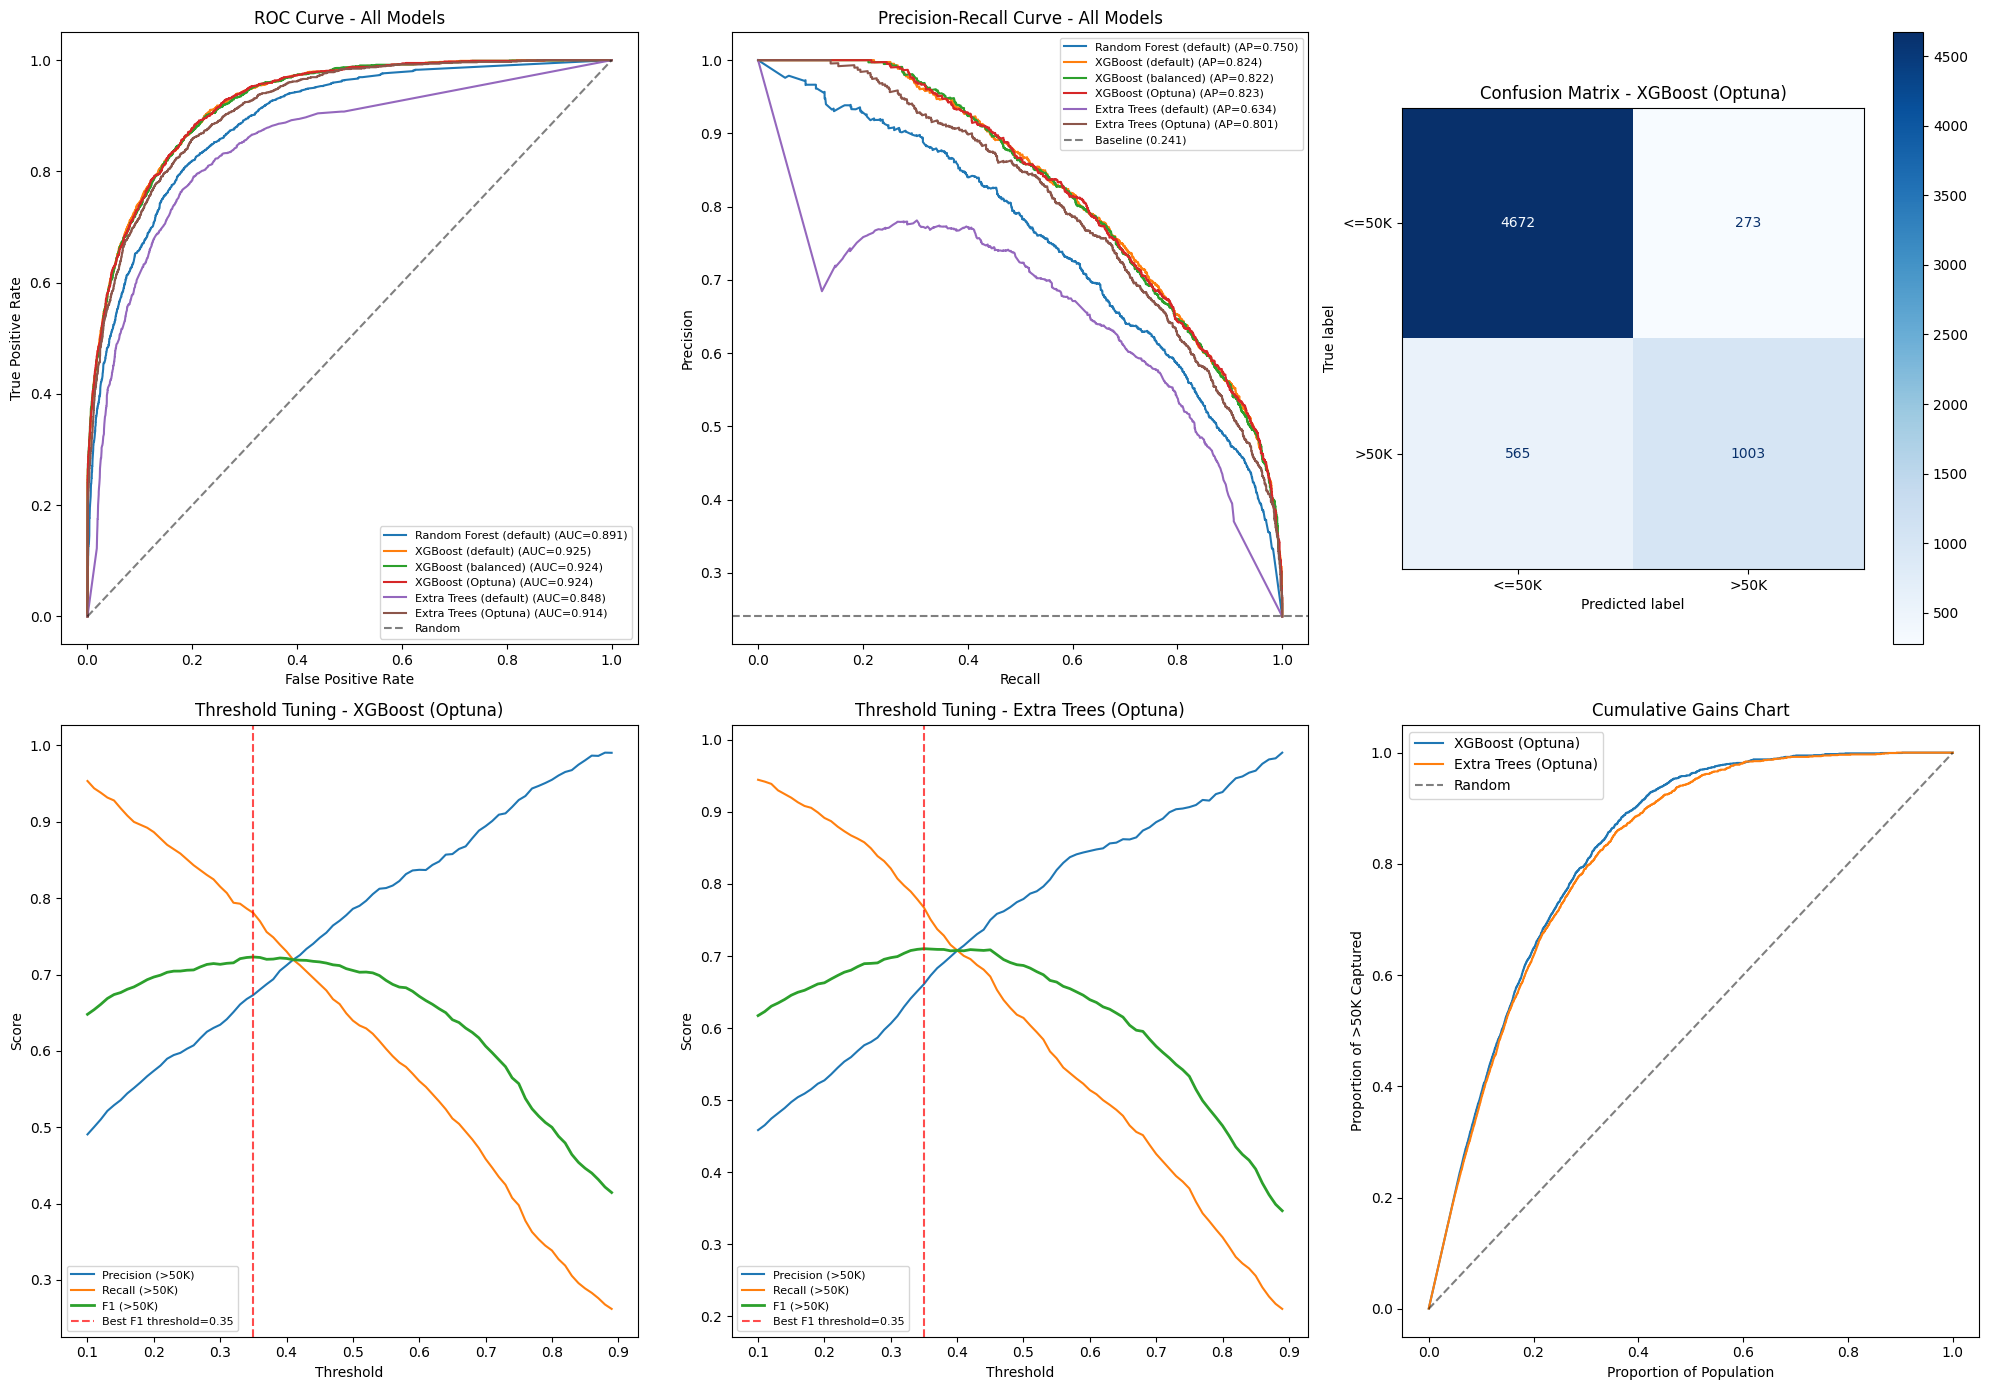

=== Best F1 Threshold (XGBoost Optuna): 0.35 ===
              precision    recall  f1-score   support

       <=50K       0.93      0.88      0.90      4945
        >50K       0.67      0.78      0.72      1568

    accuracy                           0.86      6513
   macro avg       0.80      0.83      0.81      6513
weighted avg       0.87      0.86      0.86      6513

=== Best F1 Threshold (Extra Trees Optuna): 0.35 ===
              precision    recall  f1-score   support

       <=50K       0.92      0.88      0.90      4945
        >50K       0.66      0.77      0.71      1568

    accuracy                           0.85      6513
   macro avg       0.79      0.82      0.80      6513
weighted avg       0.86      0.85      0.85      6513

=== Cumulative Gains ===
Top 10%: XGBoost captures 38.6%, Extra Trees captures 37.6% of >50K earners
Top 20%: XGBoost captures 64.9%, Extra Trees captures 63.5% of >50K earners
Top 30%: XGBoost captures 80.1%, Extra Trees captures 79.1% of >50K

In [9]:
from sklearn.metrics import (roc_curve, precision_recall_curve, average_precision_score,
                             confusion_matrix, ConfusionMatrixDisplay, f1_score)
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(20, 14))

# ============================================================
# 1. ROC Curve - All models
# ============================================================
ax1 = fig.add_subplot(2, 3, 1)
for name, (pred, proba) in models.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    ax1.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve - All Models')
ax1.legend(fontsize=8)

# ============================================================
# 2. Precision-Recall Curve - All models
# ============================================================
ax2 = fig.add_subplot(2, 3, 2)
for name, (pred, proba) in models.items():
    prec, rec, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    ax2.plot(rec, prec, label=f'{name} (AP={ap:.3f})')
baseline_rate = y_test.mean()
ax2.axhline(y=baseline_rate, color='k', linestyle='--', alpha=0.5, label=f'Baseline ({baseline_rate:.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve - All Models')
ax2.legend(fontsize=8)

# ============================================================
# 3. Confusion Matrices - Best XGBoost & Best Extra Trees
# ============================================================
ax3 = fig.add_subplot(2, 3, 3)
cm = confusion_matrix(y_test, best_pred)
ConfusionMatrixDisplay(cm, display_labels=['<=50K', '>50K']).plot(ax=ax3, cmap='Blues')
ax3.set_title('Confusion Matrix - XGBoost (Optuna)')

# ============================================================
# 4. Threshold vs Precision/Recall/F1 - Best XGBoost
# ============================================================
ax4 = fig.add_subplot(2, 3, 4)
thresholds = np.arange(0.1, 0.9, 0.01)
precisions, recalls, f1s = [], [], []
for t in thresholds:
    preds_t = (best_proba >= t).astype(int)
    report = classification_report(y_test, preds_t, output_dict=True, zero_division=0)
    precisions.append(report['1']['precision'])
    recalls.append(report['1']['recall'])
    f1s.append(report['1']['f1-score'])
ax4.plot(thresholds, precisions, label='Precision (>50K)')
ax4.plot(thresholds, recalls, label='Recall (>50K)')
ax4.plot(thresholds, f1s, label='F1 (>50K)', linewidth=2)
best_f1_idx = np.argmax(f1s)
ax4.axvline(x=thresholds[best_f1_idx], color='red', linestyle='--', alpha=0.7,
            label=f'Best F1 threshold={thresholds[best_f1_idx]:.2f}')
ax4.set_xlabel('Threshold')
ax4.set_ylabel('Score')
ax4.set_title('Threshold Tuning - XGBoost (Optuna)')
ax4.legend(fontsize=8)

# ============================================================
# 5. Threshold vs Precision/Recall/F1 - Best Extra Trees
# ============================================================
ax5 = fig.add_subplot(2, 3, 5)
et_precisions, et_recalls, et_f1s = [], [], []
for t in thresholds:
    preds_t = (best_et_proba >= t).astype(int)
    report = classification_report(y_test, preds_t, output_dict=True, zero_division=0)
    et_precisions.append(report['1']['precision'])
    et_recalls.append(report['1']['recall'])
    et_f1s.append(report['1']['f1-score'])
ax5.plot(thresholds, et_precisions, label='Precision (>50K)')
ax5.plot(thresholds, et_recalls, label='Recall (>50K)')
ax5.plot(thresholds, et_f1s, label='F1 (>50K)', linewidth=2)
best_et_f1_idx = np.argmax(et_f1s)
ax5.axvline(x=thresholds[best_et_f1_idx], color='red', linestyle='--', alpha=0.7,
            label=f'Best F1 threshold={thresholds[best_et_f1_idx]:.2f}')
ax5.set_xlabel('Threshold')
ax5.set_ylabel('Score')
ax5.set_title('Threshold Tuning - Extra Trees (Optuna)')
ax5.legend(fontsize=8)

# ============================================================
# 6. Cumulative Gains Chart - Both best models
# ============================================================
ax6 = fig.add_subplot(2, 3, 6)
# XGBoost
sorted_indices = np.argsort(-best_proba)
sorted_labels = y_test.values[sorted_indices]
cumulative_gains = np.cumsum(sorted_labels) / sorted_labels.sum()
population_pct = np.arange(1, len(sorted_labels) + 1) / len(sorted_labels)
ax6.plot(population_pct, cumulative_gains, label='XGBoost (Optuna)')
# Extra Trees
et_sorted_indices = np.argsort(-best_et_proba)
et_sorted_labels = y_test.values[et_sorted_indices]
et_cumulative_gains = np.cumsum(et_sorted_labels) / et_sorted_labels.sum()
ax6.plot(population_pct, et_cumulative_gains, label='Extra Trees (Optuna)')
ax6.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
ax6.set_xlabel('Proportion of Population')
ax6.set_ylabel('Proportion of >50K Captured')
ax6.set_title('Cumulative Gains Chart')
ax6.legend()

plt.tight_layout()
plt.show()

# ============================================================
# Text summary
# ============================================================
print(f"=== Best F1 Threshold (XGBoost Optuna): {thresholds[best_f1_idx]:.2f} ===")
best_t_preds = (best_proba >= thresholds[best_f1_idx]).astype(int)
print(classification_report(y_test, best_t_preds, target_names=['<=50K', '>50K']))

print(f"=== Best F1 Threshold (Extra Trees Optuna): {thresholds[best_et_f1_idx]:.2f} ===")
best_et_t_preds = (best_et_proba >= thresholds[best_et_f1_idx]).astype(int)
print(classification_report(y_test, best_et_t_preds, target_names=['<=50K', '>50K']))

# Cumulative gains at key percentages
print("=== Cumulative Gains ===")
for pct in [0.1, 0.2, 0.3, 0.5]:
    idx = int(pct * len(cumulative_gains)) - 1
    print(f"Top {pct*100:.0f}%: XGBoost captures {cumulative_gains[idx]*100:.1f}%, Extra Trees captures {et_cumulative_gains[idx]*100:.1f}% of >50K earners")

In [11]:
import joblib
import os

save_dir = r"C:\Users\andras.janko\Documents\CensusIncomePrediction\_models"
os.makedirs(save_dir, exist_ok=True)

# Save models
joblib.dump(xgb, os.path.join(save_dir, 'xgb_default.joblib'))
joblib.dump(xgb_balanced, os.path.join(save_dir, 'xgb_balanced.joblib'))

# Save column names (critical for inference — new data must match this format)
joblib.dump(list(X_train.columns), os.path.join(save_dir, 'feature_columns.joblib'))

print("Saved files:")
for f in os.listdir(save_dir):
    size = os.path.getsize(os.path.join(save_dir, f)) / 1024
    print(f"  {f}: {size:.1f} KB")

print(f"\nExpected features ({len(X_train.columns)}):")
print(list(X_train.columns))

Saved files:
  feature_columns.joblib: 0.6 KB
  xgb_balanced.joblib: 553.9 KB
  xgb_default.joblib: 545.5 KB

Expected features (28):
['age', 'education_num', 'marital_status', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'workclass_Local-gov', 'workclass_Private', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Unknown', 'occupation_Armed-Forces', 'occupation_Craft-repair', 'occupation_Exec-managerial', 'occupation_Farming-fishing', 'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct', 'occupation_Other-service', 'occupation_Priv-house-serv', 'occupation_Prof-specialty', 'occupation_Protective-serv', 'occupation_Sales', 'occupation_Tech-support', 'occupation_Transport-moving', 'occupation_Unknown']
